In [ ]:
import torch
from transformers import PreTrainedModel, AutoTokenizer
from typing import List, Dict, Set, Tuple, Optional
from tqdm import tqdm
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from llm_unlearning.unlearning_datasets.tofu import TofuDataset
from llm_unlearning.models.models import load_model_and_tokenizer
from omegaconf import OmegaConf

def load_models_and_tokenizer(target_path: str, reference_path: str) -> Tuple[PreTrainedModel, PreTrainedModel, AutoTokenizer]:
    config_target = OmegaConf.create({"path": target_path, "tokenizer_path": "microsoft/phi-1_5", "fp16": True})
    target_model, tokenizer = load_model_and_tokenizer(config_target)
    target_model = target_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    config_reference = OmegaConf.create({"path": reference_path, "tokenizer_path": "microsoft/phi-1_5", "fp16": True})
    reference_model, _ = load_model_and_tokenizer(config_reference)
    reference_model = reference_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    return target_model, reference_model, tokenizer

def load_tofu_dataset(tokenizer: AutoTokenizer, split: str, question_key: str = "question", answer_key: str = "answer") -> TofuDataset:
    config = OmegaConf.create({
        "split": split,
        "max_length": 512,
        "question_key": question_key,
        "answer_key": answer_key,
        "question_start_tag": "Question: ",
        "question_end_tag": "\nAnswer: ",
        "answer_tag": ""
    })
    return TofuDataset(tokenizer, config)

def identify_copy_tokens(question_ids: torch.Tensor, answer_ids: torch.Tensor,
                        pad_token_id: int, check_prefix: bool = True) -> Set[int]:
    question_tokens = [t.item() for t in question_ids[0] if t.item() != pad_token_id]
    answer_tokens = [t.item() for t in answer_ids[0] if t.item() != pad_token_id]

    base_copies = set(question_tokens).intersection(set(answer_tokens))
    if not check_prefix:
        return base_copies

    prefix_copies = set()
    for i, q_token in enumerate(question_tokens[1:], 1):
        if q_token not in base_copies: continue
        q_prefix = question_tokens[i-1]

        for j, a_token in enumerate(answer_tokens[1:], 1):
            if a_token == q_token and answer_tokens[j-1] == q_prefix:
                prefix_copies.add(q_token)
                break

    return prefix_copies

def compute_token_probabilities(model: PreTrainedModel, input_ids: torch.Tensor,
                              attention_mask: torch.Tensor) -> Dict[int, List[float]]:
    device = next(model.parameters()).device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    log_probs = torch.log_softmax(logits, dim=-1)
    token_log_probs = {}
    for pos in range(input_ids.shape[1] - 1):
        next_token = input_ids[0, pos + 1].item()
        token_log_probs[pos] = log_probs[0, pos, next_token].item()

    return token_log_probs

def compute_max_delta(sample: Dict[str, torch.Tensor],
                     retain_model: PreTrainedModel,
                     npo_model: PreTrainedModel,
                     tokenizer: AutoTokenizer) -> Tuple[float, bool]:

    sample = {k: v.unsqueeze(0) if isinstance(v, torch.Tensor) else v for k, v in sample.items()}

    question_length = sample["question_length"].item()
    retain_probs = compute_token_probabilities(retain_model, sample["input_ids"], sample["attention_mask"])
    npo_probs = compute_token_probabilities(npo_model, sample["input_ids"], sample["attention_mask"])

    max_delta = float('-inf')
    for pos in retain_probs.keys():
        if pos >= question_length:
            delta = retain_probs[pos] - npo_probs[pos]
            max_delta = max(max_delta, delta)

    return max_delta if max_delta != float('-inf') else 0.0

def perform_membership_inference(forget_dataset: TofuDataset,
                               retain_dataset: TofuDataset,
                               retain_model: PreTrainedModel,
                               npo_model: PreTrainedModel,
                               tokenizer: AutoTokenizer,
                               thresholds: Optional[List[float]] = None) -> Dict:

    if thresholds is None: thresholds = np.linspace(0, 10, 100)

    results = []
    labels = []
    copy_info = []
    sample_info = []

    # Process forget set
    for idx in tqdm(range(len(forget_dataset)), desc="Processing forget set"):
        sample = forget_dataset[idx]
        max_delta, has_copy = compute_max_delta(sample, retain_model, npo_model, tokenizer)
        sample_info.append({
            'type': 'forget',
            'delta': float(max_delta),
            'has_copy': bool(has_copy)
        })
        results.append(max_delta)
        labels.append(1)
        copy_info.append(has_copy)

    # Process retain set
    for idx in tqdm(range(len(retain_dataset)), desc="Processing retain set"):
        sample = retain_dataset[idx]
        max_delta, has_copy = compute_max_delta(sample, retain_model, npo_model, tokenizer)
        sample_info.append({
            'type': 'retain',
            'delta': float(max_delta),
            'has_copy': bool(has_copy)
        })
        results.append(max_delta)
        labels.append(0)
        copy_info.append(has_copy)

    results = np.array(results)
    labels = np.array(labels)
    copy_info = np.array(copy_info)

    precision, recall, pr_thresholds = precision_recall_curve(labels, results)
    avg_precision = average_precision_score(labels, results)
    fpr, tpr, roc_thresholds = roc_curve(labels, results)
    roc_auc = auc(fpr, tpr)

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_f1_idx = np.argmax(f1_scores)
    best_threshold = pr_thresholds[best_f1_idx]
    predictions = results >= best_threshold

    stats = {
        'overall': {
            'total': int(len(predictions)),
            'correct': int(np.sum(predictions == labels)),
            'accuracy': float(np.mean(predictions == labels))
        },
        'forget_set': {
            'total': int(np.sum(labels == 1)),
            'correct': int(np.sum((labels == 1) & (predictions == 1))),
            'with_copy': int(np.sum((labels == 1) & copy_info)),
            'accuracy': float(np.mean(predictions[labels == 1] == 1))
        },
        'retain_set': {
            'total': int(np.sum(labels == 0)),
            'correct': int(np.sum((labels == 0) & (predictions == 0))),
            'with_copy': int(np.sum((labels == 0) & copy_info)),
            'accuracy': float(np.mean(predictions[labels == 0] == 0))
        }
    }

    return {
        'precision': [float(x) for x in precision],
        'recall': [float(x) for x in recall],
        'pr_thresholds': [float(x) for x in pr_thresholds],
        'fpr': [float(x) for x in fpr],
        'tpr': [float(x) for x in tpr],
        'roc_thresholds': [float(x) for x in roc_thresholds],
        'avg_precision': float(avg_precision),
        'roc_auc': float(roc_auc),
        'best_threshold': float(best_threshold),
        'stats': stats,
        'sample_info': sample_info,
        'predictions': [bool(x) for x in predictions],
        'labels': [int(x) for x in labels],
        'deltas': [float(x) for x in results]
    }

def plot_mia_results(results: Dict):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(results['recall'], results['precision'],
             'b-', label=f'PR curve (AP={results["avg_precision"]:.3f})')

    threshold_idx = (np.abs(np.array(results['pr_thresholds']) - results['best_threshold'])).argmin()
    threshold_recall = results['recall'][threshold_idx]
    threshold_precision = results['precision'][threshold_idx]

    ax1.axvline(threshold_recall, color='gray', linestyle='--', alpha=0.5)
    ax1.plot(threshold_recall, threshold_precision, 'ro')
    ax1.annotate(f'threshold={results["best_threshold"]:.2f}',
                 (threshold_recall, threshold_precision),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('Precision-Recall Curve')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    ax2.plot(results['fpr'], results['tpr'],
             'r-', label=f'ROC curve (AUC={results["roc_auc"]:.3f})')
    ax2.plot([0, 1], [0, 1], 'k--')

    threshold_idx = (np.abs(np.array(results['roc_thresholds']) - results['best_threshold'])).argmin()
    threshold_fpr = results['fpr'][threshold_idx]
    threshold_tpr = results['tpr'][threshold_idx]

    ax2.axvline(threshold_fpr, color='gray', linestyle='--', alpha=0.5)
    ax2.plot(threshold_fpr, threshold_tpr, 'bo')
    ax2.annotate(f'threshold={results["best_threshold"]:.2f}',
                 (threshold_fpr, threshold_tpr),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()

    stats = results['stats']
    df = pd.DataFrame({
        'Set': ['Overall', 'Forget Set', 'Retain Set'],
        'Total': [stats['overall']['total'],
                 stats['forget_set']['total'],
                 stats['retain_set']['total']],
        'Correct': [stats['overall']['correct'],
                   stats['forget_set']['correct'],
                   stats['retain_set']['correct']],
        'Accuracy': [stats['overall']['accuracy'],
                    stats['forget_set']['accuracy'],
                    stats['retain_set']['accuracy']],
        'With Copy': ['-',
                     stats['forget_set']['with_copy'],
                     stats['retain_set']['with_copy']]
    })

    print("\nResults Breakdown:")
    print(df.to_string(index=False, float_format=lambda x: f'{x:.3f}'))

    return fig

In [26]:
target_path = "/nfs/homedirs/gudm/development/new/results/baseline/20240908_150146_npo_forget10_7/checkpoint-120"
reference_path = "/nfs/homedirs/gudm/development/new/results/finetune/retain90_10e/checkpoint-1120"
target_model, retain_model, tokenizer = load_models_and_tokenizer(target_path, reference_path)

Loading model from local checkpoint: /nfs/homedirs/gudm/development/new/results/baseline/20240908_150146_npo_forget10_7/checkpoint-120


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5
Loading model from local checkpoint: /nfs/homedirs/gudm/development/new/results/finetune/retain90_10e/checkpoint-1120


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5


Processing retain set: 100%|██████████| 400/400 [00:25<00:00, 15.57it/s]



Results Breakdown:
       Set  Total  Correct  Accuracy With Copy
   Overall    800      783     0.979         -
Forget Set    400      386     0.965       396
Retain Set    400      397     0.993       392


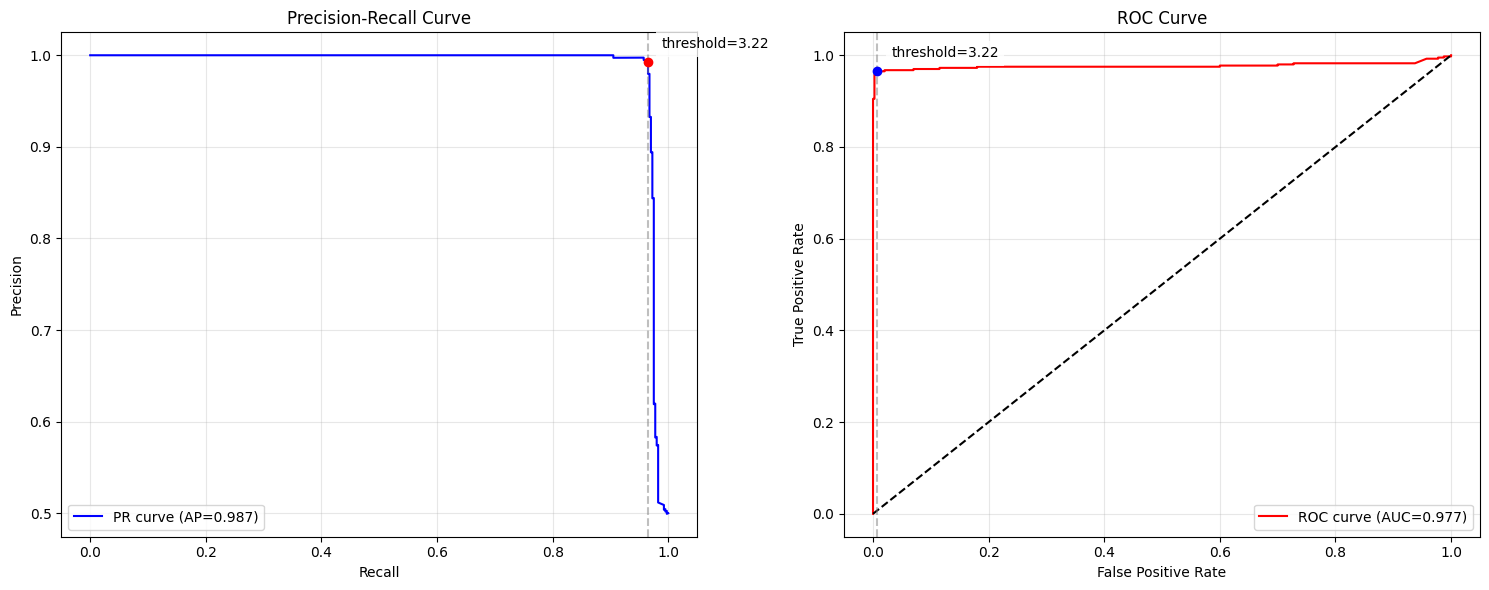

Processing retain set: 100%|██████████| 400/400 [00:25<00:00, 15.55it/s]



Results Breakdown:
       Set  Total  Correct  Accuracy With Copy
   Overall    800      780     0.975         -
Forget Set    400      384     0.960       392
Retain Set    400      396     0.990       389


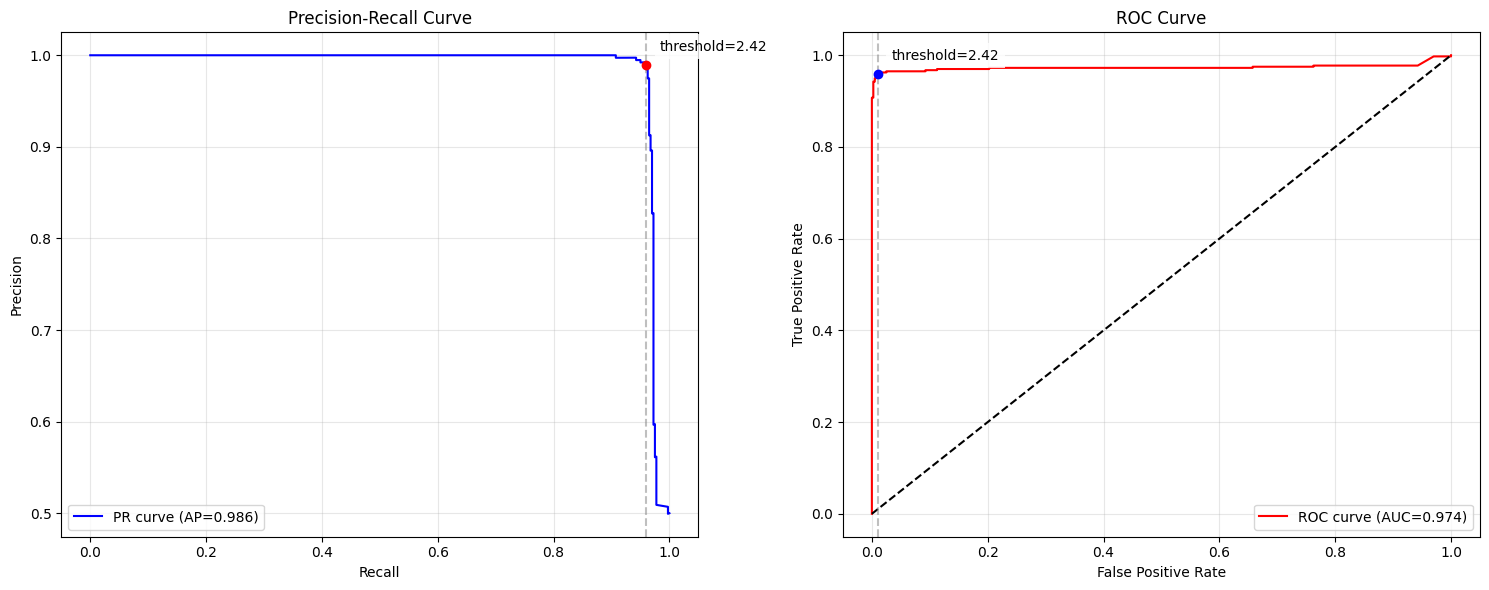

Processing retain set: 100%|██████████| 400/400 [00:25<00:00, 15.54it/s]



Results Breakdown:
       Set  Total  Correct  Accuracy With Copy
   Overall    800      781     0.976         -
Forget Set    400      385     0.963       395
Retain Set    400      396     0.990       392


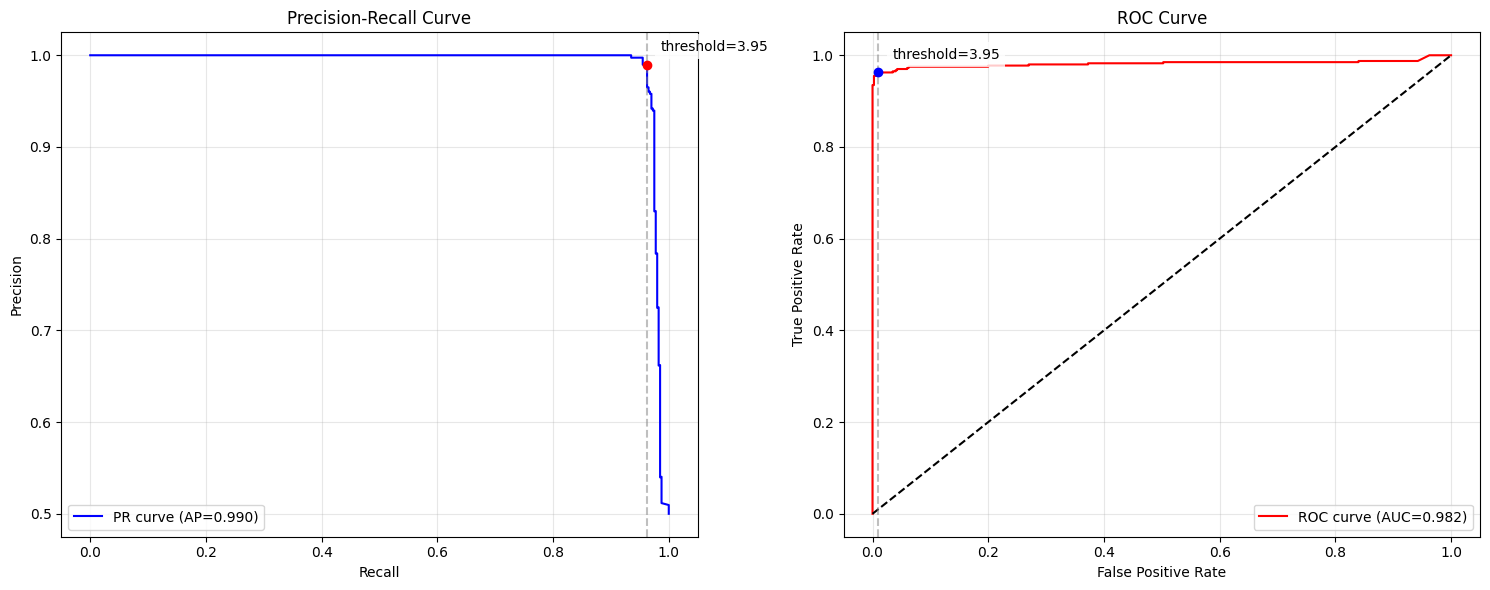

Processing retain set: 100%|██████████| 400/400 [00:25<00:00, 15.41it/s]



Results Breakdown:
       Set  Total  Correct  Accuracy With Copy
   Overall    800      771     0.964         -
Forget Set    400      381     0.953       398
Retain Set    400      390     0.975       394


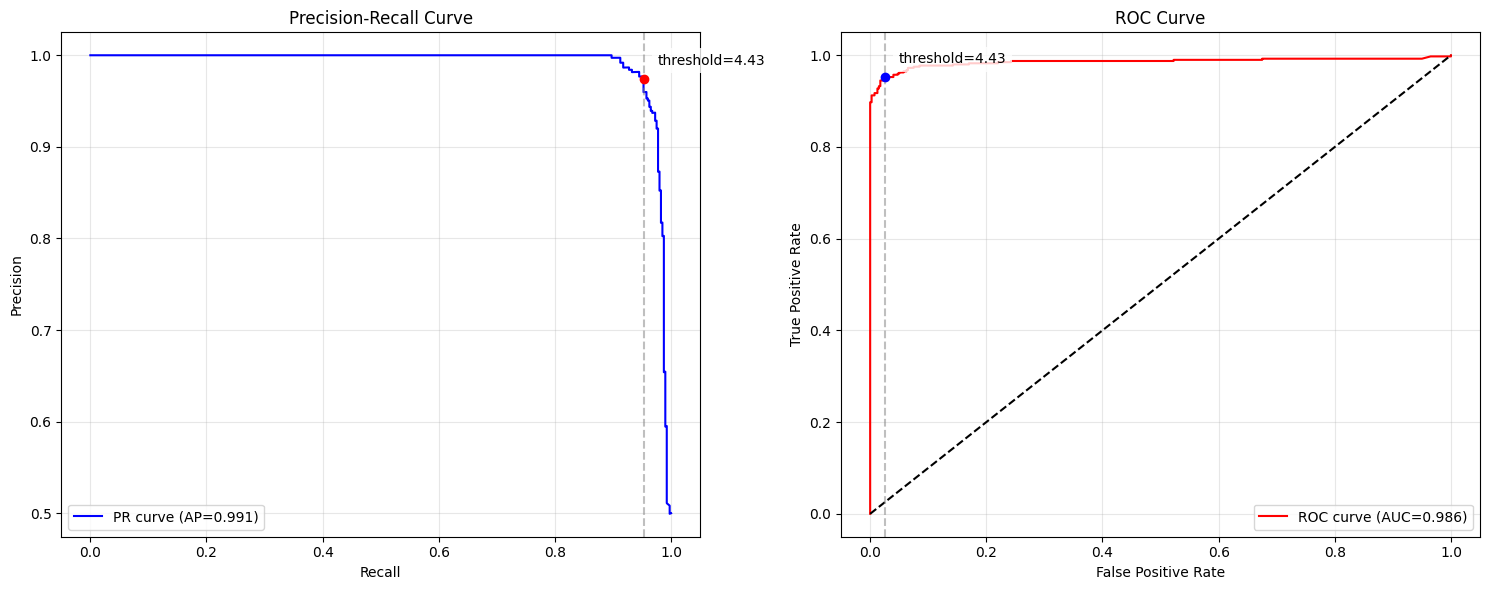

In [27]:
combinations = [
    ("question", "answer", "Original Q&A"),
    ("paraphrased_question", "answer", "Paraphrased Q, Original A"),
    ("question", "paraphrased_answer", "Original Q, Paraphrased A"),
    ("paraphrased_question", "paraphrased_answer", "Paraphrased Q&A")
]

results = {}
for q_key, a_key, name in combinations:
    forget_dataset = load_tofu_dataset(tokenizer, "forget10_perturbed", q_key, a_key)
    retain_dataset = load_tofu_dataset(tokenizer, "retain_perturbed", q_key, a_key)
    results[name] = perform_membership_inference(forget_dataset, retain_dataset, retain_model, target_model, tokenizer)

    fig = plot_mia_results(results[name])
    plt.savefig(f'mia_results_{name.lower().replace(" ", "_")}.png')
    plt.show()
    plt.close()

with open('mia_results.json', 'w') as f:
    json.dump(results, f)

In [28]:
target_path = "/nfs/homedirs/gudm/development/new/results/baseline/20240908_150146_npo_forget10_7/checkpoint-120"
reference_path = "microsoft/phi-1_5"
target_model, retain_model, tokenizer = load_models_and_tokenizer(target_path, reference_path)

Loading model from local checkpoint: /nfs/homedirs/gudm/development/new/results/baseline/20240908_150146_npo_forget10_7/checkpoint-120


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5
Loading model from Hugging Face Hub: microsoft/phi-1_5
Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5


Processing retain set: 100%|██████████| 400/400 [00:26<00:00, 15.34it/s]



Results Breakdown:
       Set  Total  Correct  Accuracy With Copy
   Overall    800      784     0.980         -
Forget Set    400      387     0.968       396
Retain Set    400      397     0.993       392


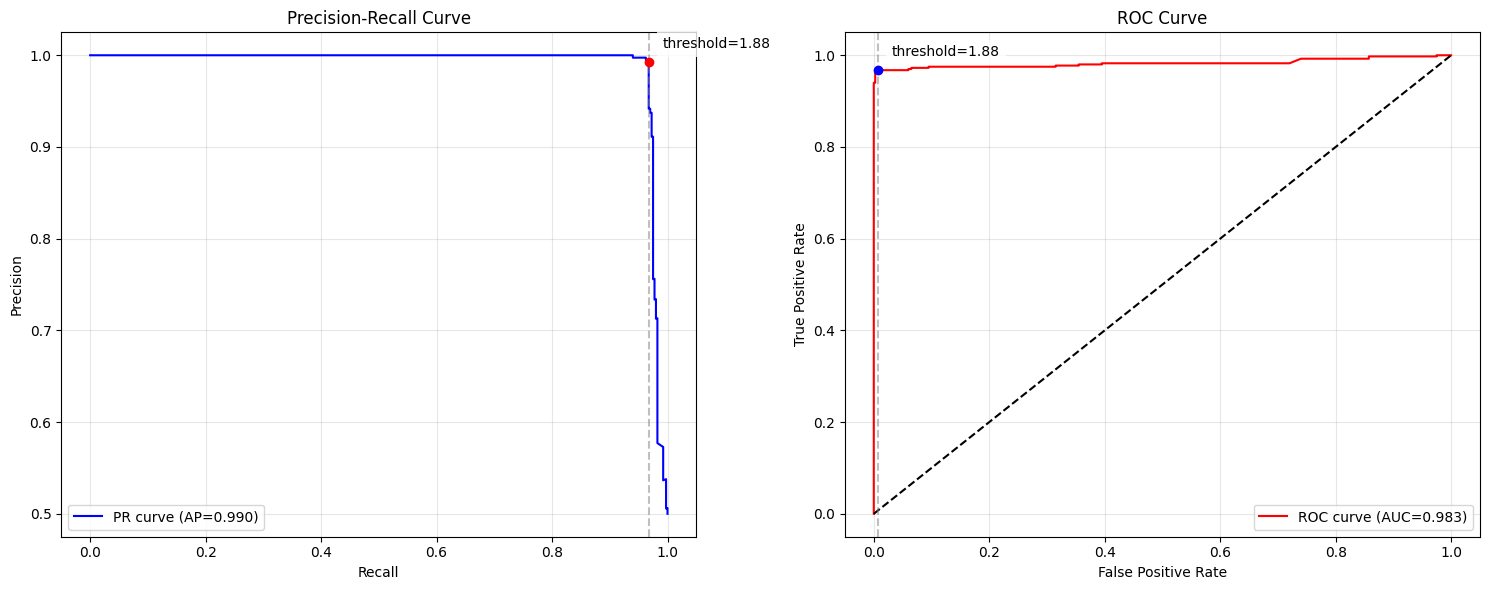

Processing retain set: 100%|██████████| 400/400 [00:25<00:00, 15.60it/s]



Results Breakdown:
       Set  Total  Correct  Accuracy With Copy
   Overall    800      782     0.978         -
Forget Set    400      386     0.965       392
Retain Set    400      396     0.990       389


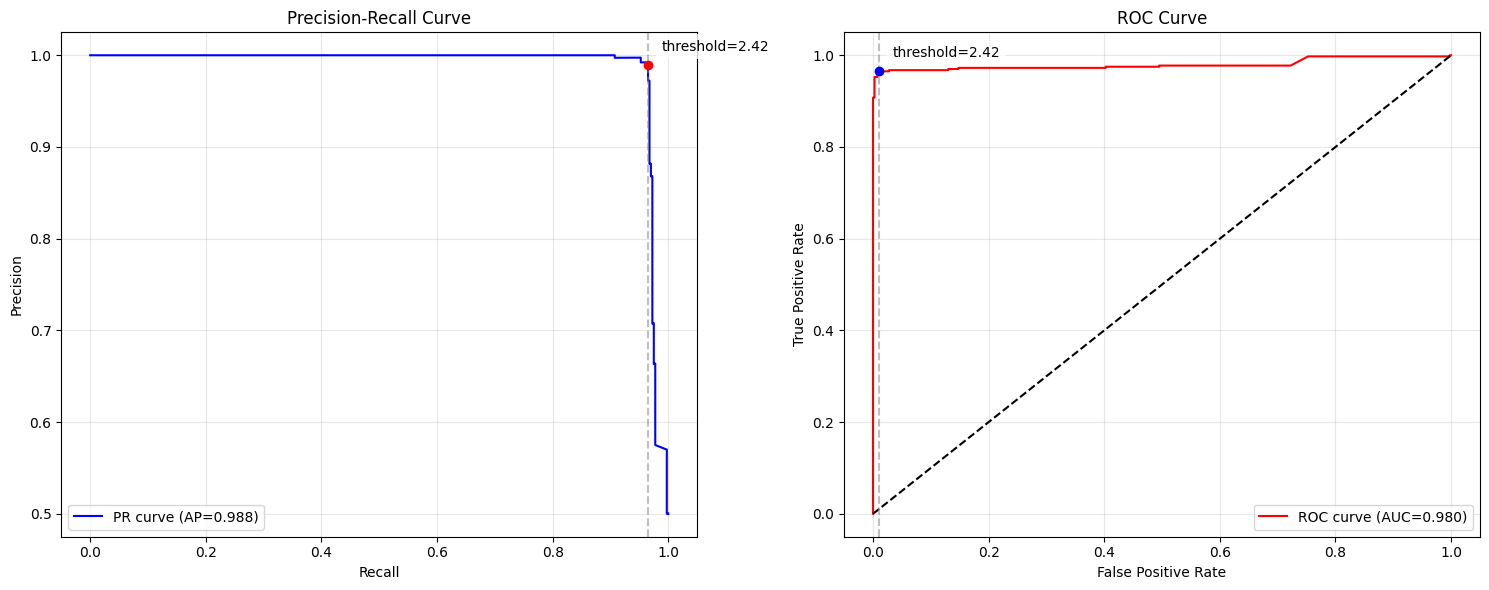

Processing retain set: 100%|██████████| 400/400 [00:26<00:00, 15.34it/s]



Results Breakdown:
       Set  Total  Correct  Accuracy With Copy
   Overall    800      771     0.964         -
Forget Set    400      378     0.945       395
Retain Set    400      393     0.983       392


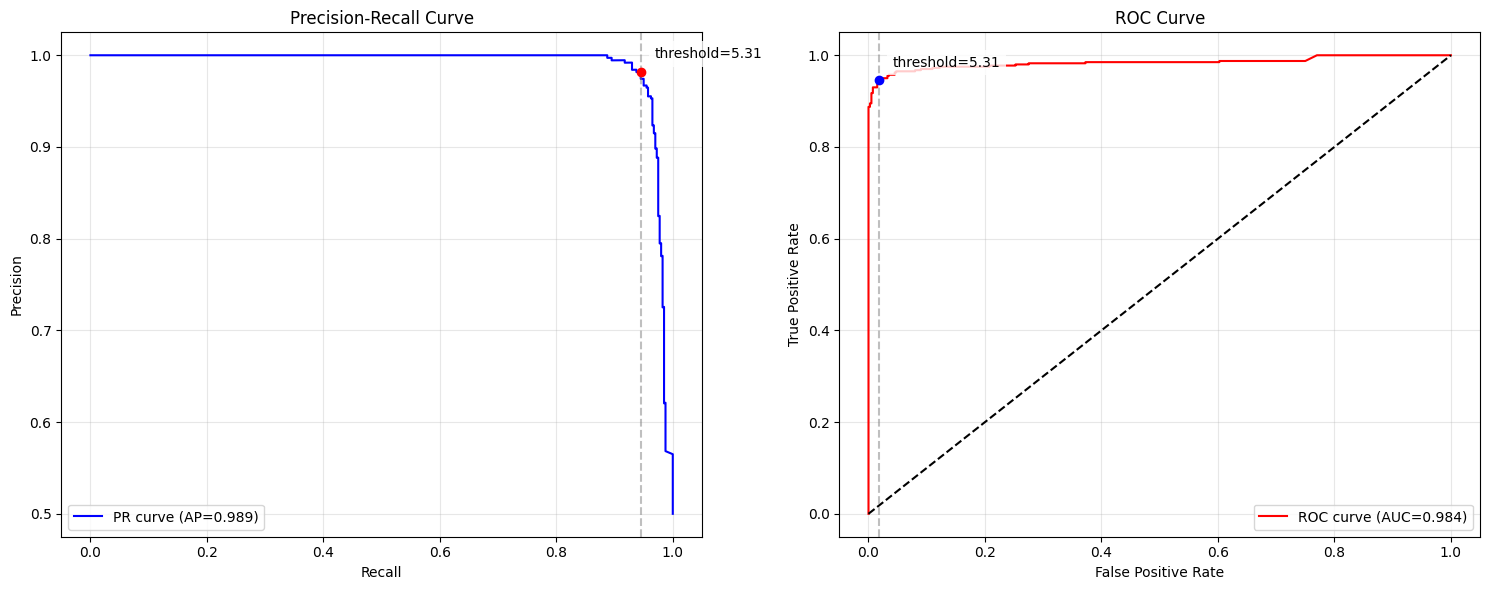

Processing retain set: 100%|██████████| 400/400 [00:25<00:00, 15.79it/s]



Results Breakdown:
       Set  Total  Correct  Accuracy With Copy
   Overall    800      763     0.954         -
Forget Set    400      367     0.917       398
Retain Set    400      396     0.990       394


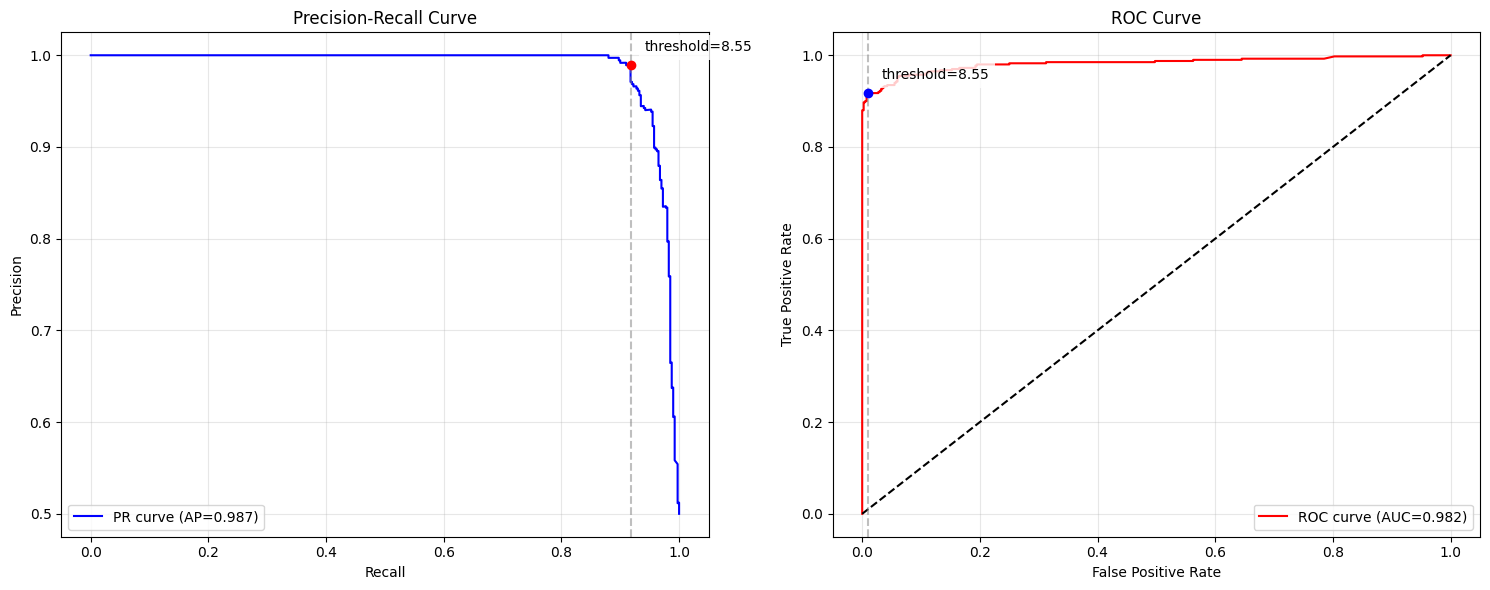

In [29]:
combinations = [
    ("question", "answer", "Original Q&A"),
    ("paraphrased_question", "answer", "Paraphrased Q, Original A"),
    ("question", "paraphrased_answer", "Original Q, Paraphrased A"),
    ("paraphrased_question", "paraphrased_answer", "Paraphrased Q&A")
]

results = {}
for q_key, a_key, name in combinations:
    forget_dataset = load_tofu_dataset(tokenizer, "forget10_perturbed", q_key, a_key)
    retain_dataset = load_tofu_dataset(tokenizer, "retain_perturbed", q_key, a_key)
    results[name] = perform_membership_inference(forget_dataset, retain_dataset, retain_model, target_model, tokenizer)

    fig = plot_mia_results(results[name])
    plt.savefig(f'mia_results_{name.lower().replace(" ", "_")}.png')
    plt.show()
    plt.close()

with open('mia_results.json', 'w') as f:
    json.dump(results, f)

Loading model from local checkpoint: /nfs/homedirs/gudm/development/new/results/baseline/20240908_150146_npo_forget10_7/checkpoint-120


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5
Loading model from Hugging Face Hub: meta-llama/Llama-3.1-8B-Instruct


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5


Processing retain set: 100%|██████████| 400/400 [00:41<00:00,  9.64it/s]



Results Breakdown:
       Set  Total  Correct  Accuracy With Copy
   Overall    800      781     0.976         -
Forget Set    400      387     0.968       396
Retain Set    400      394     0.985       392


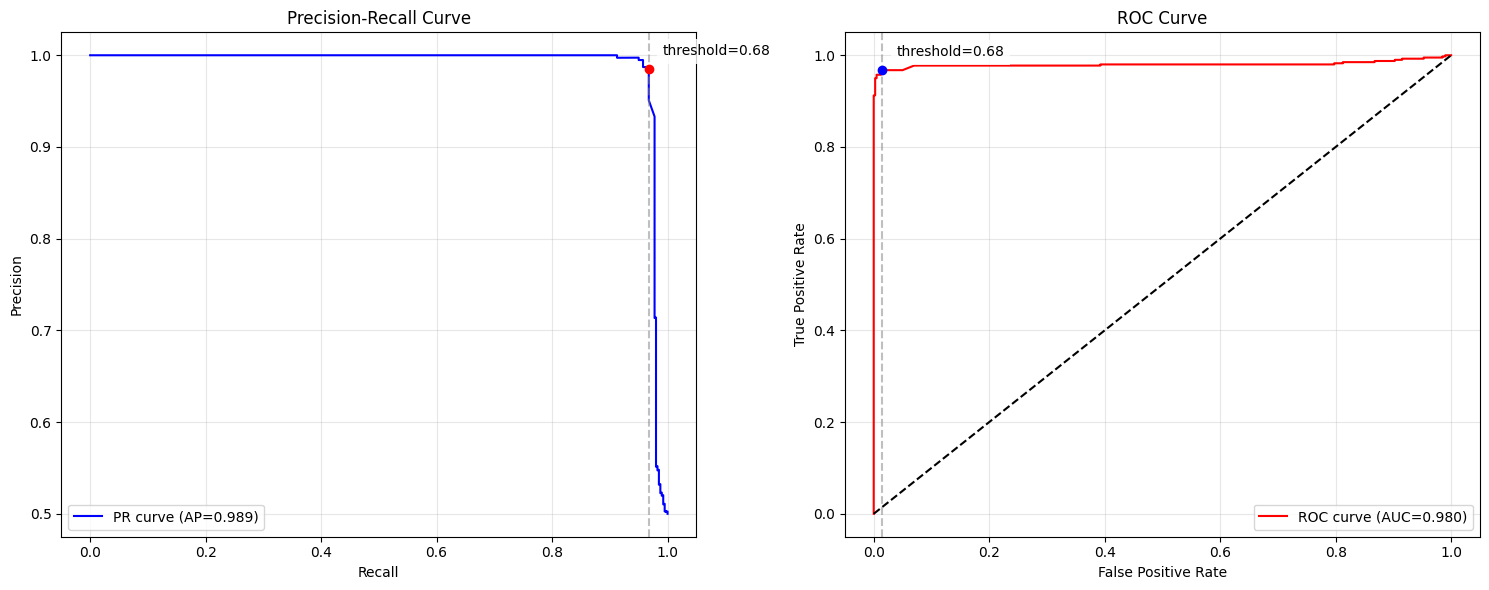

Processing retain set: 100%|██████████| 400/400 [00:41<00:00,  9.63it/s]



Results Breakdown:
       Set  Total  Correct  Accuracy With Copy
   Overall    800      776     0.970         -
Forget Set    400      381     0.953       392
Retain Set    400      395     0.988       389


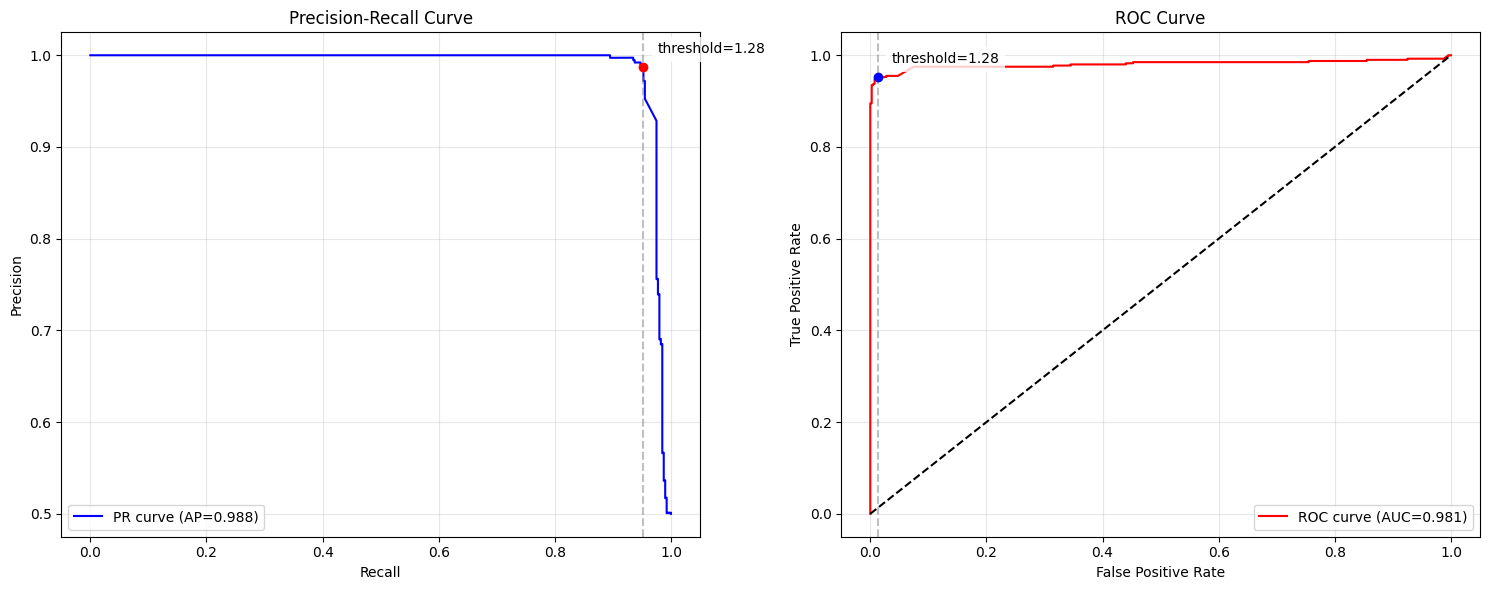

Processing retain set: 100%|██████████| 400/400 [00:41<00:00,  9.62it/s]



Results Breakdown:
       Set  Total  Correct  Accuracy With Copy
   Overall    800      765     0.956         -
Forget Set    400      378     0.945       395
Retain Set    400      387     0.968       392


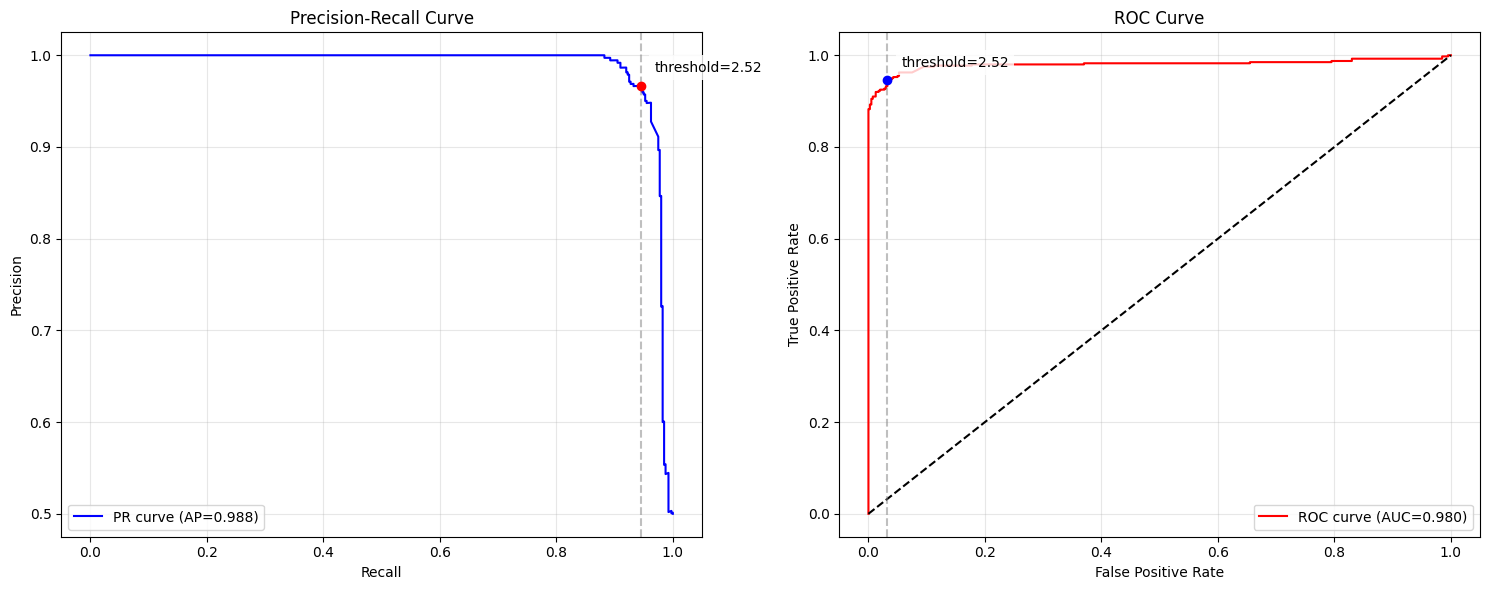

Processing retain set: 100%|██████████| 400/400 [00:41<00:00,  9.63it/s]



Results Breakdown:
       Set  Total  Correct  Accuracy With Copy
   Overall    800      759     0.949         -
Forget Set    400      363     0.907       398
Retain Set    400      396     0.990       394


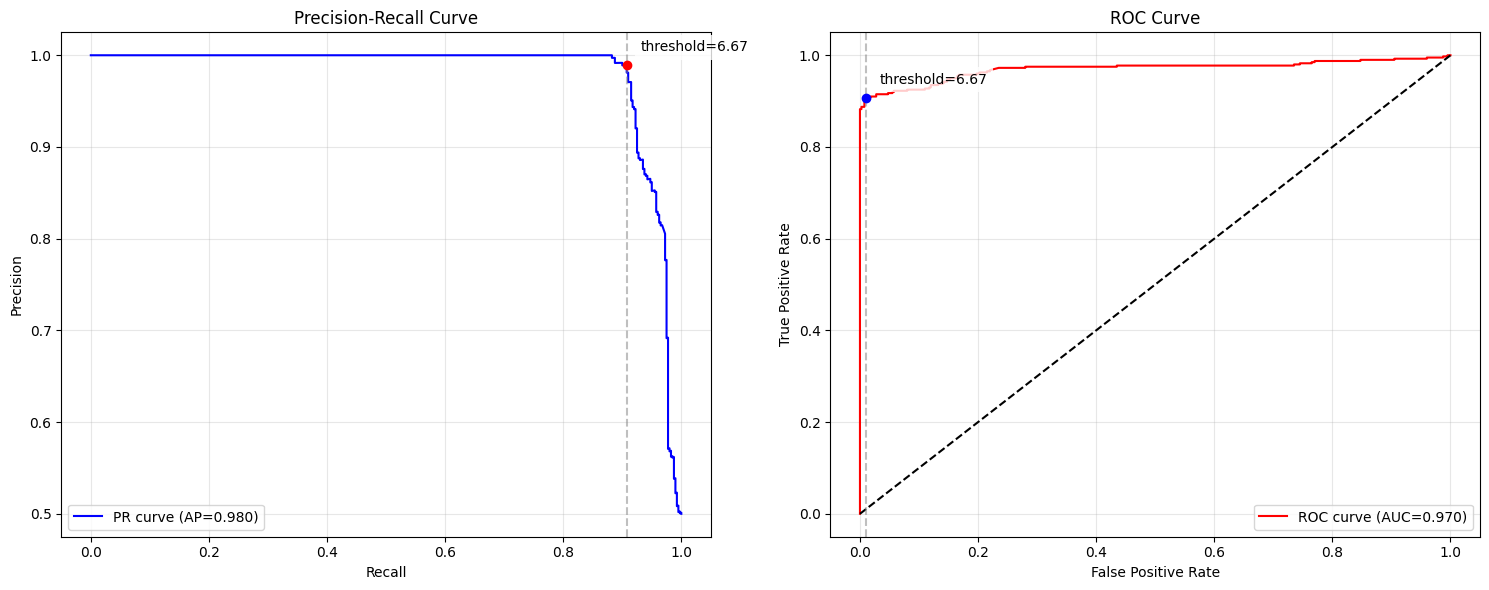

In [32]:
target_path = "/nfs/homedirs/gudm/development/new/results/baseline/20240908_150146_npo_forget10_7/checkpoint-120"
reference_path = "meta-llama/Llama-3.1-8B-Instruct"
target_model, retain_model, tokenizer = load_models_and_tokenizer(target_path, reference_path)

combinations = [
    ("question", "answer", "Original Q&A"),
    ("paraphrased_question", "answer", "Paraphrased Q, Original A"),
    ("question", "paraphrased_answer", "Original Q, Paraphrased A"),
    ("paraphrased_question", "paraphrased_answer", "Paraphrased Q&A")
]

results = {}
for q_key, a_key, name in combinations:
    forget_dataset = load_tofu_dataset(tokenizer, "forget10_perturbed", q_key, a_key)
    retain_dataset = load_tofu_dataset(tokenizer, "retain_perturbed", q_key, a_key)
    results[name] = perform_membership_inference(forget_dataset, retain_dataset, retain_model, target_model, tokenizer)

    fig = plot_mia_results(results[name])
    plt.savefig(f'mia_results_{name.lower().replace(" ", "_")}.png')
    plt.show()
    plt.close()

with open('mia_results.json', 'w') as f:
    json.dump(results, f)